In [1]:
import sys
import os
import gc
from datetime import date

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
# Mount your google drive in google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
os.chdir('/content/drive/My Drive/10708')
print("Current Working Directory: ", os.getcwdb())


%run Stock_Data.ipynb

Current Working Directory:  b'/content/drive/My Drive/10708'
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
[*********************100%***********************]  1 of 1 completed
(8315, 7)
                   Open         High          Low    Adj Close      Volume  Log Return       vol
Date                                                                                            
1990-01-02   353.399994   359.690002   351.980011   359.690002   162070000    0.000000       NaN
1990-01-03   359.690002   360.589996   357.890015   358.760010   192330000   -0.258889       NaN
1990-01-04   358.760010   358.760010   352.890015   355.670013   177000000   -0.865030       NaN
1990-01-05   355.670013   355.670013   351.350006   352.200012   158530000   -0.980414       NaN
1990-01-08   352.200012   354.239990   350.540009   353.790009   140110000    0.450431       NaN
...                 ...          ...          ...          ...         ...        

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
look_back = 90
config = {
    "size_hidden_layer" : 128,
    "size_input" : 9,
    "size_output" : 1,
    "num_layers" : 3,
    "drop_out" : 0.2,
    "lr" : 1e-3,
    "batch_size" : 32,
    "train_ratio" : 0.8,
    "val_ratio" : 0.1,
    "epochs" : 20
}

In [5]:
class LSTM_DataLoader():
    def __init__(self, dataset, train_ratio, valid_ratio, look_back, batch_size):
        # Scaler
        self.feature_scaler = MinMaxScaler()
        self.vol_scaler = MinMaxScaler()
        # Data
        self.data = dataset
        self.extended_data = self.extend_dataset()
        self.features = None
        self.ret_labels = None
        self.close_labels = None
        # split dataset into test-validate-training datasets according to these ratios
        self.train_ratio = train_ratio
        self.valid_ratio = valid_ratio
        # Number of days to look back for return prediction
        self.look_back = look_back
        # Batch size
        self.batch_size = batch_size

    def extend_dataset(self):
        dataset = self.data
        close_prices = dataset["Adj Close"].tolist()
        # calculate 12-EMA and 26-EMA
        factor_12 = 2 / (12 + 1)
        EMAs_12 = [close_prices[0]]
        for i in range(1, len(close_prices)):
            if i < 12:
                EMAs_12.append((EMAs_12[-1] * i + close_prices[i]) / (i + 1))
            else:
                EMAs_12.append((EMAs_12[-1] * (1 - factor_12) + close_prices[i] * factor_12))
        
        EMAs_12_series = pd.Series(EMAs_12, index=dataset.index.tolist())
        dataset["12-day-EMA"] = EMAs_12_series

        factor_26 = 2 / (26 + 1)
        EMAs_26 = [close_prices[0]]
        for i in range(1, len(close_prices)):
            if i < 26:
                EMAs_26.append((EMAs_26[-1] * i + close_prices[i]) / (i + 1))
            else:
                EMAs_26.append((EMAs_26[-1] * (1 - factor_26) + close_prices[i] * factor_26))
        
        EMAs_26_series = pd.Series(EMAs_26, index=dataset.index.tolist())
        dataset["26-day-EMA"] = EMAs_26_series

        # calculate volatility
        dataset["10-day-vol"] = dataset["Log Return"].rolling(10).std(ddof=0)
        dataset["30-day-vol"] = dataset["Log Return"].rolling(30).std(ddof=0)

        # calculate volume change
        dataset["Log Volume"] = np.log(dataset["Volume"])
        dataset["Log Volume Chg"] = np.insert(np.diff(dataset["Log Volume"]), 0, 0)
        
        # calculate range
        dataset["Log Range"] = np.log(dataset["High"] / dataset["Low"]) * 100

        # calculate EMA-related cols
        dataset["EMA-12 Chg"] = np.insert(np.diff(dataset["12-day-EMA"]), 0, 0)
        dataset["EMA-26 Chg"] = np.insert(np.diff(dataset["26-day-EMA"]), 0, 0)

        VIX_data = Stock_Data(
                "^VIX",
                1990, 1, 2,
                2022, 12, 31,
                freq="1d",
                scaling_factor=100,
              ) 
        dataset["VIX"] = VIX_data.get_raw_data()["Adj Close"]

        ffr_df = pd.read_csv('FEDFUNDS.csv')
        ffr_df = ffr_df.rename(columns={"FEDFUNDS": "Fed Fund Rate"})
        ffr_df["DATE"] = pd.to_datetime(ffr_df["DATE"])
        ffr_df = ffr_df.set_index('DATE')
        ffr_df = ffr_df.reindex(pd.date_range(start=date(1990, 1, 1), end=date(2023, 1, 1), freq='1D'))
        ffr_df = ffr_df.fillna(method="ffill")
        dataset = dataset.join(ffr_df)

        return dataset


    def build_datasets(self):
        """
        Return scaler, X's and Y's
        """
        dataset = self.extended_data

        # group columns to get X's
        if self.look_back >= 30:
            start_index = self.look_back + 30
        else:
            start_index = 30
        # build indices
        indices = dataset.index.tolist()[start_index:]

        vol_10 = dataset["10-day-vol"].values.reshape(-1, 1)
        vol_30 = dataset["30-day-vol"].values.reshape(-1, 1)
        log_range = dataset["Log Range"].values.reshape(-1, 1)
        log_return = dataset["Log Return"].values.reshape(-1, 1)
        log_vlmchg = dataset["Log Volume Chg"].values.reshape(-1, 1)
        EMA12_chg = dataset["EMA-12 Chg"].values.reshape(-1, 1)
        EMA26_chg = dataset["EMA-26 Chg"].values.reshape(-1, 1)
        vix = dataset["VIX"].values.reshape(-1, 1)
        ffr = dataset["Fed Fund Rate"].values.reshape(-1, 1)

        features = vol_10
        features = np.append(features, vol_30, axis = 1)
        features = np.append(features, log_range, axis = 1)
        features = np.append(features, log_return, axis = 1)
        features = np.append(features, log_vlmchg, axis = 1)
        features = np.append(features, EMA12_chg, axis = 1)
        features = np.append(features, EMA26_chg, axis = 1)
        features = np.append(features, vix, axis = 1)
        features = np.append(features, ffr, axis = 1)

        # 10-day-vol label
        vol_labels = dataset["10-day-vol"][start_index:].tolist()[10:]
        vol_labels = pd.Series(vol_labels, index=indices[:-10])
        
        # features
        features = features[start_index - self.look_back + 1:]
        # drop the last 10 row
        features = features[:-10]

        print(features)
        print(vol_labels)

        self.features = features
        self.vol_labels = vol_labels


    def get_datasets(self):
        data_len = self.vol_labels.shape[0]
        train_split = int(data_len * self.train_ratio)
        print('Training Set length - ', str(train_split))

        val_split = train_split + int(data_len * self.valid_ratio)
        print('Validation Set length - ', str(val_split - train_split))

        print('Test Set length - ', str(data_len - val_split))

        # Prepare data
        features = self.features
        vol_labels = self.vol_labels

        # Normalize all values in the dataframe (both inputs and outputs)
        features = self.feature_scaler.fit_transform(features)

        # Shall we normalize labels?
        indices = list(vol_labels.index.values)
        vol_labels = self.vol_scaler.fit_transform(vol_labels.values.reshape(-1, 1))
        vol_labels = pd.DataFrame(vol_labels, columns=["10-day-vol"], index=indices)
        
        # Splitting features and labels into train, validation and test samples
        X_train = features[:train_split + self.look_back - 1]
        X_val = features[train_split:val_split + self.look_back - 1]
        X_test = features[val_split:]
        Y_train, Y_val, Y_test = vol_labels[:train_split], vol_labels[train_split:val_split], vol_labels[val_split:]
        
        self.X_train = X_train
        self.X_val = X_val
        self.X_test = X_test
        self.Y_train = Y_train
        self.Y_val = Y_val
        self.Y_test = Y_test

        #print shape of samples
        print(X_train.shape, X_val.shape, X_test.shape)
        print(Y_train.shape, Y_val.shape, Y_test.shape)


    def next_batch(self, data_type):
        if data_type == "train":
            inputs = torch.from_numpy(self.X_train)
            targets = torch.from_numpy(self.Y_train.values.reshape(-1, 1))
        elif data_type == "val":
            inputs = torch.from_numpy(self.X_val)
            targets = torch.from_numpy(self.Y_val.values.reshape(-1, 1))
        else:
            inputs = torch.from_numpy(self.X_test)
            targets = torch.from_numpy(self.Y_test.values.reshape(-1, 1))
        
        sequence_length = self.look_back
        
        i = 0
        cur_batch = list()
        cur_label = list()
        cur_batch_len = 0
        while i + sequence_length <= inputs.shape[0]:
            cur_batch.append(inputs[i:i + sequence_length, :])
            cur_label.append(targets[i, :])
            cur_batch_len += 1
            i += 1

            if cur_batch_len == self.batch_size:
                yield(torch.from_numpy(np.stack(cur_batch)), torch.from_numpy(np.stack(cur_label)))
                cur_batch = list()
                cur_label = list()
                cur_batch_len = 0
        
        if cur_batch_len > 0:
            yield(torch.from_numpy(np.stack(cur_batch)), torch.from_numpy(np.stack(cur_label))) 
    

In [6]:
# Sanity check
torch.set_default_dtype(torch.float64)
LSTM_DL = LSTM_DataLoader(raw_data, config["train_ratio"], config["val_ratio"], look_back, config["batch_size"])
LSTM_DL.build_datasets()
LSTM_DL.get_datasets()
i = 0
for input, label in LSTM_DL.next_batch("train"):
    print(input)
    print(label)
    i = i + 1
    if i == 1:
        break

[*********************100%***********************]  1 of 1 completed
[[ 0.615397    0.96392343  0.77127324 ... -0.32989938 22.04999924
   8.24      ]
 [ 0.65314572  0.97750687  1.07976402 ... -0.0921287  19.70999908
   8.24      ]
 [ 0.67676638  0.97049692  0.96399306 ... -0.24604608 20.78000069
   8.24      ]
 ...
 [ 1.3457957   1.5313684   2.66707346 ...  5.3305167  22.54999924
   4.1       ]
 [ 0.94823745  1.53405809  2.19750964 ...  3.13345368 21.13999939
   4.1       ]
 [ 1.17200293  1.53358442  2.01389755 ... -4.47421462 22.82999992
   4.1       ]]
1990-06-22    0.660984
1990-06-25    0.655725
1990-06-26    0.742789
1990-06-27    0.771042
1990-06-28    0.762989
                ...   
2022-12-09    1.243743
2022-12-12    1.115841
2022-12-13    1.068358
2022-12-14    1.277887
2022-12-15    1.058322
Length: 8185, dtype: float64
Training Set length -  6548
Validation Set length -  818
Test Set length -  819
(6637, 9) (907, 9) (908, 9)
(6548, 1) (818, 1) (819, 1)
tensor([[[0.0680, 0.1

In [7]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()

        self.relu = nn.ReLU()
        self.lstm = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=config["num_layers"], 
                                  dropout=config["drop_out"], batch_first=True, bias=True)
        self.linear = nn.Linear(in_features=hidden_size, out_features=output_size, bias=True)


    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.relu(x)
        x = self.linear(x)
        return x

In [8]:
# Train Step
def train(DL, model, optimizer, criterion):
    num_batch = DL.X_train.shape[0] // DL.batch_size + (DL.X_train.shape[0] % DL.batch_size)
    if DL.X_train.shape[0] % DL.batch_size != 0:
        num_batch += 1
    batch_bar = tqdm(total=num_batch, dynamic_ncols=True, leave=False, position=0, desc='Train')
    train_loss = 0
    model.train()

    i = 0
    num_sample = 0
    for (input, target) in DL.next_batch("train"):
        input, target = input.to(device), target.to(device)

        curr_lr = optimizer.param_groups[0]['lr']
        optimizer.zero_grad()
        prediction = model(input)
        loss = criterion(prediction.flatten(), target.flatten())
        loss.backward()
        optimizer.step()

        batch_size = input.shape[0]
        num_sample += batch_size
        train_loss += loss.item() * batch_size

        batch_bar.set_postfix(
            loss = f"{train_loss / num_sample:.4f}",
            lr = f"{curr_lr}",
        )
        batch_bar.update()

        torch.cuda.empty_cache()
        del input
        del target
    
    batch_bar.close()
    
    train_loss /= num_sample
    return train_loss

In [9]:
# Validate Step
def validate(DL, model, criterion):
    num_batch = DL.X_val.shape[0] // DL.batch_size + (DL.X_val.shape[0] % DL.batch_size)
    if DL.X_val.shape[0] % DL.batch_size != 0:
        num_batch += 1
    batch_bar = tqdm(total=num_batch, dynamic_ncols=True, leave=False, position=0, desc='Validate')
    val_loss = 0
    model.eval()

    i = 0
    num_sample = 0
    for (input, target) in DL.next_batch("val"):
        input, target = input.to(device), target.to(device)

        with torch.inference_mode():
            prediction = model(input)
        loss = criterion(prediction.flatten(), target.flatten())

        batch_size = input.shape[0]
        num_sample += batch_size
        val_loss += loss.item() * batch_size

        batch_bar.set_postfix(
            loss = f"{val_loss / num_sample:.4f}"
        )
        batch_bar.update()

        torch.cuda.empty_cache()
        del input
        del target
    
    batch_bar.close()
    
    val_loss /= num_sample
    return val_loss

In [10]:
# Predict Step
def predict(DL, model, criterion):
    num_batch = DL.X_test.shape[0] // DL.batch_size + (DL.X_test.shape[0] % DL.batch_size)
    if DL.X_test.shape[0] % DL.batch_size != 0:
        num_batch += 1
    batch_bar = tqdm(total=num_batch, dynamic_ncols=True, leave=False, position=0, desc='Predict')
    
    test_loss = 0
    predictions = np.array(list())
    model.eval()

    i = 0
    num_sample = 0
    for (input, target) in DL.next_batch("test"):
        input, target = input.to(device), target.to(device)

        with torch.inference_mode():
            prediction = model(input)
        loss = criterion(prediction.flatten(), target.flatten())

        batch_size = input.shape[0]
        num_sample += batch_size
        test_loss += loss.item() * batch_size

        batch_bar.set_postfix(
            loss = f"{test_loss / num_sample:.4f}"
        )
        batch_bar.update()

        prediction = prediction.cpu().detach().numpy()
        predictions = np.concatenate((predictions, prediction.flatten()), axis=None)

        torch.cuda.empty_cache()
        del input
        del target
    
    batch_bar.close()
    
    test_loss /= num_sample
    return test_loss, predictions

In [11]:
# Prepare Dataloader, model, optimizer, criterion, and scheduler_lr
torch.set_default_dtype(torch.float64)
LSTM_DL = LSTM_DataLoader(raw_data, config["train_ratio"], config["val_ratio"], look_back, config["batch_size"])
LSTM_DL.build_datasets()
LSTM_DL.get_datasets()

model = LSTM(config['size_input'], config['size_hidden_layer'], config['size_output']).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'], weight_decay = 5e-5)
criterion = nn.MSELoss()
scheduler_lr = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.75, patience=2, verbose=True)

[*********************100%***********************]  1 of 1 completed
[[ 0.615397    0.96392343  0.77127324 ... -0.32989938 22.04999924
   8.24      ]
 [ 0.65314572  0.97750687  1.07976402 ... -0.0921287  19.70999908
   8.24      ]
 [ 0.67676638  0.97049692  0.96399306 ... -0.24604608 20.78000069
   8.24      ]
 ...
 [ 1.3457957   1.5313684   2.66707346 ...  5.3305167  22.54999924
   4.1       ]
 [ 0.94823745  1.53405809  2.19750964 ...  3.13345368 21.13999939
   4.1       ]
 [ 1.17200293  1.53358442  2.01389755 ... -4.47421462 22.82999992
   4.1       ]]
1990-06-22    0.660984
1990-06-25    0.655725
1990-06-26    0.742789
1990-06-27    0.771042
1990-06-28    0.762989
                ...   
2022-12-09    1.243743
2022-12-12    1.115841
2022-12-13    1.068358
2022-12-14    1.277887
2022-12-15    1.058322
Length: 8185, dtype: float64
Training Set length -  6548
Validation Set length -  818
Test Set length -  819
(6637, 9) (907, 9) (908, 9)
(6548, 1) (818, 1) (819, 1)


In [12]:
# Train loop
torch.cuda.empty_cache()
gc.collect()

train_loss, val_loss = 0, 0

for epoch in range(config["epochs"]):
    
    curr_lr = optimizer.param_groups[0]['lr']

    train_loss = train(LSTM_DL, model, optimizer, criterion)

    val_loss = validate(LSTM_DL, model, criterion)

    scheduler_lr.step(train_loss)

    print("\nEpoch {}/{}: \n\t Train Loss {:.07f}\t Eval Loss {:.07f}\t Learning Rate {:.04f}\t".format(
          epoch + 1,
          config['epochs'],
          train_loss,
          val_loss,
          curr_lr))
    
# Predict 
torch.cuda.empty_cache()
gc.collect()

test_loss, predictions = predict(LSTM_DL, model, criterion)

loss = 'Test loss: {:.07}'.format(test_loss)
print(loss)


Epoch 1/20: 
	 Train Loss 0.0061710	 Eval Loss 0.0060515	 Learning Rate 0.0010	



Epoch 2/20: 
	 Train Loss 0.0057136	 Eval Loss 0.0059967	 Learning Rate 0.0010	



Epoch 3/20: 
	 Train Loss 0.0053785	 Eval Loss 0.0055867	 Learning Rate 0.0010	



Epoch 4/20: 
	 Train Loss 0.0059206	 Eval Loss 0.0046185	 Learning Rate 0.0010	



Epoch 5/20: 
	 Train Loss 0.0041722	 Eval Loss 0.0041553	 Learning Rate 0.0010	



Epoch 6/20: 
	 Train Loss 0.0032967	 Eval Loss 0.0030239	 Learning Rate 0.0010	



Epoch 7/20: 
	 Train Loss 0.0033855	 Eval Loss 0.0039828	 Learning Rate 0.0010	



Epoch 8/20: 
	 Train Loss 0.0029227	 Eval Loss 0.0039297	 Learning Rate 0.0010	



Epoch 9/20: 
	 Train Loss 0.0034767	 Eval Loss 0.0039669	 Learning Rate 0.0010	



Epoch 10/20: 
	 Train Loss 0.0044329	 Eval Loss 0.0040362	 Learning Rate 0.0010	


Epoch 00011: reducing learning rate of group 0 to 7.5000e-04.

Epoch 11/20: 
	 Train Loss 0.0033091	 Eval Loss 0.0033046	 Learning Rate 0.0010	



Epoch 12/20: 
	 Train Loss 0.0028775	 Eval Loss 0.0025555	 Learning Rate 0.0008	



Epoch 13/20: 
	 Train Loss 0.0029009	 Eval Loss 0.0026275	 Learning Rate 0.0008	



Epoch 14/20: 
	 Train Loss 0.0029059	 Eval Loss 0.0026363	 Learning Rate 0.0008	



Epoch 15/20: 
	 Train Loss 0.0028303	 Eval Loss 0.0026204	 Learning Rate 0.0008	



Epoch 16/20: 
	 Train Loss 0.0028575	 Eval Loss 0.0026475	 Learning Rate 0.0008	



Epoch 17/20: 
	 Train Loss 0.0027691	 Eval Loss 0.0027205	 Learning Rate 0.0008	



Epoch 18/20: 
	 Train Loss 0.0028176	 Eval Loss 0.0027728	 Learning Rate 0.0008	



Epoch 19/20: 
	 Train Loss 0.0027595	 Eval Loss 0.0026806	 Learning Rate 0.0008	



Epoch 20/20: 
	 Train Loss 0.0027867	 Eval Loss 0.0027040	 Learning Rate 0.0008	


Test loss: 0.008077091


mse:  0.39724581458252245


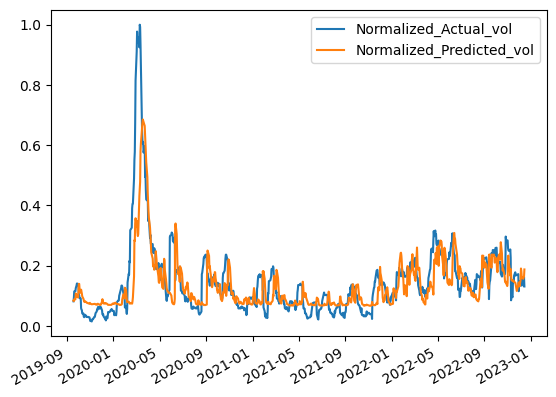

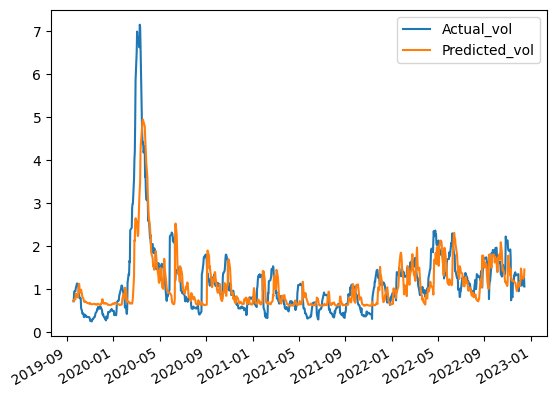

In [13]:
# Plot
nvol_pred_label = pd.DataFrame(LSTM_DL.Y_test.values, columns=["Normalized_Actual_vol"], index=LSTM_DL.Y_test.index)
nvol_pred_label["Normalized_Predicted_vol"] = predictions
nvol_pred_label.plot()

avol_pred_label = pd.DataFrame(LSTM_DL.vol_scaler.inverse_transform(LSTM_DL.Y_test.values.reshape(-1, 1)), columns=["Actual_vol"], index=LSTM_DL.Y_test.index)
avol_pred_label["Predicted_vol"] = LSTM_DL.vol_scaler.inverse_transform(predictions.reshape(-1, 1))

avol_pred_label.plot()

mse = mean_squared_error(avol_pred_label["Actual_vol"].values, avol_pred_label["Predicted_vol"].values)
print("mse: ", mse)
